In [ ]:

import torch
import torch.nn as nn

class EvoformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(EvoformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim),
        )

    def forward(self, x):
        # Self-attention
        attn_output, _ = self.attention(x, x, x)
        x = x + attn_output
        # Feed-forward
        ff_output = self.feed_forward(x)
        x = x + ff_output
        return x

class AlphaFoldSimplified(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers):
        super(AlphaFoldSimplified, self).__init__()
        self.layers = nn.ModuleList(
            [EvoformerBlock(embed_dim, num_heads) for _ in range(num_layers)]
        )
        self.output_layer = nn.Linear(embed_dim, 3)  # 3D coordinates

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.output_layer(x)

# Example usage
model = AlphaFoldSimplified(embed_dim=128, num_heads=8, num_layers=12)
sequence = torch.randn(64, 128)  # Example input: 64 residues, 128 features
structure = model(sequence)      # Output: Predicted 3D coordinates
print(structure.shape)           # Output shape: [64, 3]



In [ ]:

import torch
import torch.nn as nn
import torch.optim as optim

# Evoformer Block (simplified)
class EvoformerBlock(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(EvoformerBlock, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads)
        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * 4),
            nn.ReLU(),
            nn.Linear(embed_dim * 4, embed_dim),
        )
        self.layer_norm1 = nn.LayerNorm(embed_dim)
        self.layer_norm2 = nn.LayerNorm(embed_dim)

    def forward(self, x):
        # Self-attention
        attn_output, _ = self.attention(x, x, x)
        x = self.layer_norm1(x + attn_output)
        # Feed-forward
        ff_output = self.feed_forward(x)
        x = self.layer_norm2(x + ff_output)
        return x

# AlphaFold-like Model
class AlphaFoldSimplified(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers):
        super(AlphaFoldSimplified, self).__init__()
        self.embedding = nn.Embedding(20, embed_dim)  # 20 amino acids
        self.layers = nn.ModuleList(
            [EvoformerBlock(embed_dim, num_heads) for _ in range(num_layers)]
        )
        self.structure_head = nn.Linear(embed_dim, 3)  # Predict 3D coordinates

    def forward(self, sequence):
        # Embed amino acid sequence
        x = self.embedding(sequence)  # [Batch, Sequence Length, Embedding Dim]
        print(f"Shape after embedding: {x.shape}")
        x = x.permute(1, 0, 2)  # [Sequence Length, Batch, Embedding Dim] for Attention
        for layer in self.layers:
            x = layer(x)
        x = x.permute(1, 0, 2)  # Back to [Batch, Sequence Length, Embedding Dim]
        coordinates = self.structure_head(x)  # [Batch, Sequence Length, 3]
        print(f"Shape after structure head: {coordinates.shape}")
        return coordinates

# Generate Random Data
def generate_random_data(batch_size, seq_length, embed_dim):
    sequences = torch.randint(0, 20, (batch_size, seq_length))  # Random amino acids
    coordinates = torch.randn(batch_size, seq_length, 3)  # Simulated 3D coordinates
    print(f"Generated sequences shape: {sequences.shape}")
    print(f"Generated coordinates shape: {coordinates.shape}")
    return sequences, coordinates

# Training Loop
def train_model(model, optimizer, criterion, epochs, batch_size, seq_length, embed_dim):
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for _ in range(10):  # Simulating 10 batches per epoch
            # Generate random data
            sequences, coordinates = generate_random_data(batch_size, seq_length, embed_dim)
            optimizer.zero_grad()
            # Forward pass
            pred_coordinates = model(sequences)
            # Compute loss
            loss = criterion(pred_coordinates, coordinates)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}, Loss: {total_loss / 10:.4f}")

# Usage Example
def use_model(model, sequence):
    model.eval()
    with torch.no_grad():
        predicted_coords = model(sequence)
    return predicted_coords

# Model Hyperparameters
embed_dim = 128
num_heads = 8
num_layers = 6
batch_size = 16
seq_length = 64
epochs = 5

# Initialize model, optimizer, and loss function
model = AlphaFoldSimplified(embed_dim, num_heads, num_layers)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Train the model
train_model(model, optimizer, criterion, epochs, batch_size, seq_length, embed_dim)

# Test the model
test_sequence = torch.randint(0, 20, (1, seq_length))  # Single random test sequence
print(f"\nTest sequence shape: {test_sequence.shape}")
predicted_coordinates = use_model(model, test_sequence)

print("\nPredicted 3D Coordinates:")
print(predicted_coordinates.shape)



In [ ]:

Generated sequences shape: torch.Size([16, 64])
Generated coordinates shape: torch.Size([16, 64, 3])
Shape after embedding: torch.Size([16, 64, 128])
Shape after structure head: torch.Size([16, 64, 3])
Test sequence shape: torch.Size([1, 64])



In [2]:

import numpy as np

class HopfieldNetwork:
    def __init__(self, size):
        self.size = size
        self.weights = np.zeros((size, size))
    
    def train(self, patterns):
        for p in patterns:
            self.weights += np.outer(p, p)
        np.fill_diagonal(self.weights, 0)  # No self-connections
        self.weights /= len(patterns)
    
    def recall(self, pattern, steps=10):
        for _ in range(steps):
            pattern = np.sign(np.dot(self.weights, pattern))
        return pattern

# Example: Network Traffic Anomaly Detection
# Train on normal traffic patterns
patterns = np.array([
    [1, -1, 1, -1],  # Pattern 1 (normal)
    [-1, 1, -1, 1],  # Pattern 2 (normal)
])
hopfield = HopfieldNetwork(size=4)
hopfield.train(patterns)

# Test with an anomaly (noisy pattern)
test_pattern = [1, -1, -1, 1]
recalled_pattern = hopfield.recall(test_pattern)

print("Test Pattern:", test_pattern)
print("Recalled Pattern:", recalled_pattern)



Test Pattern: [1, -1, -1, 1]
Recalled Pattern: [ 1. -1. -1.  1.]


In [3]:

import numpy as np

class HopfieldNetwork:
    def __init__(self, size):
        self.size = size
        self.weights = np.zeros((size, size))
    
    def train(self, patterns):
        # Train the network using Hebbian learning
        for p in patterns:
            self.weights += np.outer(p, p)
        np.fill_diagonal(self.weights, 0)  # No self-connections
        self.weights /= len(patterns)  # Normalize by the number of patterns
        print("Trained Weights Matrix:")
        print(self.weights)
    
    def recall(self, pattern, steps=10):
        # Recall a pattern and attempt to converge to a stored state
        pattern = np.array(pattern)
        for step in range(steps):
            updated_pattern = np.sign(np.dot(self.weights, pattern))
            if np.array_equal(updated_pattern, pattern):
                break  # Converged to a stable state
            pattern = updated_pattern
        return pattern

    def is_anomaly(self, test_pattern, stored_patterns):
        # Check if the test pattern matches any stored pattern
        recalled_pattern = self.recall(test_pattern)
        for stored in stored_patterns:
            if np.array_equal(recalled_pattern, stored):
                return False  # Not an anomaly
        return True  # Anomaly detected

# Example: Network Traffic Patterns
# Each pattern represents a simplified snapshot of network traffic (binary features)
stored_patterns = np.array([
    [1, -1, 1, -1],  # Normal traffic pattern 1
    [-1, 1, -1, 1],  # Normal traffic pattern 2
    [1, 1, -1, -1],  # Normal traffic pattern 3
])

# Initialize Hopfield Network
hopfield = HopfieldNetwork(size=4)
hopfield.train(stored_patterns)

# Test patterns
test_patterns = [
    [1, -1, 1, -1],  # Exact match (should not be an anomaly)
    [-1, 1, -1, 1],  # Exact match (should not be an anomaly)
    [1, -1, -1, 1],  # Noisy pattern (should converge to a stored pattern)
    [-1, -1, -1, -1],  # Completely new pattern (should be an anomaly)
]

# Check each test pattern
for i, test_pattern in enumerate(test_patterns):
    print(f"\nTest Pattern {i + 1}: {test_pattern}")
    is_anomaly = hopfield.is_anomaly(test_pattern, stored_patterns)
    if is_anomaly:
        print("Result: Anomaly detected!")
    else:
        print("Result: No anomaly (normal traffic).")



Trained Weights Matrix:
[[ 0.         -0.33333333  0.33333333 -1.        ]
 [-0.33333333  0.         -1.          0.33333333]
 [ 0.33333333 -1.          0.         -0.33333333]
 [-1.          0.33333333 -0.33333333  0.        ]]

Test Pattern 1: [1, -1, 1, -1]
Result: No anomaly (normal traffic).

Test Pattern 2: [-1, 1, -1, 1]
Result: No anomaly (normal traffic).

Test Pattern 3: [1, -1, -1, 1]
Result: Anomaly detected!

Test Pattern 4: [-1, -1, -1, -1]
Result: Anomaly detected!


In [4]:

import numpy as np

class RBM:
    def __init__(self, num_visible, num_hidden, learning_rate=0.1):
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.learning_rate = learning_rate

        # Initialize weights and biases
        self.weights = np.random.randn(num_hidden, num_visible) * 0.1  # Weight matrix
        self.hidden_bias = np.zeros(num_hidden)  # Bias for hidden units
        self.visible_bias = np.zeros(num_visible)  # Bias for visible units

    def sigmoid(self, x):
        return 1.0 / (1.0 + np.exp(-x))

    def sample_probabilities(self, probabilities):
        return np.random.binomial(1, probabilities)

    def forward_pass(self, visible):
        # Compute probabilities for hidden units given visible units
        hidden_activations = np.dot(visible, self.weights.T) + self.hidden_bias
        hidden_probabilities = self.sigmoid(hidden_activations)
        return hidden_probabilities

    def backward_pass(self, hidden):
        # Compute probabilities for visible units given hidden units
        visible_activations = np.dot(hidden, self.weights) + self.visible_bias
        visible_probabilities = self.sigmoid(visible_activations)
        return visible_probabilities

    def train(self, data, epochs=10):
        for epoch in range(epochs):
            epoch_error = 0
            for sample in data:
                # Positive phase
                positive_hidden_probs = self.forward_pass(sample)
                positive_hidden_states = self.sample_probabilities(positive_hidden_probs)
                positive_associations = np.outer(positive_hidden_states, sample)

                # Negative phase
                negative_visible_probs = self.backward_pass(positive_hidden_states)
                negative_hidden_probs = self.forward_pass(negative_visible_probs)
                negative_associations = np.outer(negative_hidden_probs, negative_visible_probs)

                # Update weights and biases
                self.weights += self.learning_rate * (positive_associations - negative_associations)
                self.visible_bias += self.learning_rate * (sample - negative_visible_probs)
                self.hidden_bias += self.learning_rate * (positive_hidden_probs - negative_hidden_probs)

                # Compute reconstruction error
                epoch_error += np.sum((sample - negative_visible_probs) ** 2)

            print(f"Epoch {epoch + 1}, Reconstruction Error: {epoch_error:.4f}")

    def reconstruct(self, input_data):
        # Reconstruct visible data from hidden activations
        hidden_probs = self.forward_pass(input_data)
        visible_reconstructed = self.backward_pass(hidden_probs)
        return visible_reconstructed

# Example usage

# Binary dataset (e.g., encoded as 0 and 1)
data = np.array([
    [1, 0, 1, 0, 1, 0],
    [0, 1, 0, 1, 0, 1],
    [1, 1, 1, 0, 0, 0],
    [0, 0, 0, 1, 1, 1]
])

# Initialize RBM
num_visible = data.shape[1]
num_hidden = 4
rbm = RBM(num_visible=num_visible, num_hidden=num_hidden, learning_rate=0.1)

# Train RBM
rbm.train(data, epochs=10)

# Test reconstruction
test_sample = np.array([1, 0, 1, 0, 0, 0])  # New input
reconstructed = rbm.reconstruct(test_sample)

print("\nOriginal Input:", test_sample)
print("Reconstructed Output:", np.round(reconstructed))



Epoch 1, Reconstruction Error: 5.9312
Epoch 2, Reconstruction Error: 6.1411
Epoch 3, Reconstruction Error: 6.6300
Epoch 4, Reconstruction Error: 6.0998
Epoch 5, Reconstruction Error: 5.7415
Epoch 6, Reconstruction Error: 6.6329
Epoch 7, Reconstruction Error: 5.5944
Epoch 8, Reconstruction Error: 5.8463
Epoch 9, Reconstruction Error: 5.3694
Epoch 10, Reconstruction Error: 7.0422

Original Input: [1 0 1 0 0 0]
Reconstructed Output: [1. 0. 1. 0. 1. 0.]


In [ ]:

Anomaly Detection:
Compare reconstruction error for inputs. High error suggests that the pattern does not match learned normal patterns.


In [5]:

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Diffusion Model Core
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, timesteps):
        super(DiffusionModel, self).__init__()
        self.timesteps = timesteps
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x, t):
        # Concatenate time step as an additional input
        t_embedding = torch.sin(torch.linspace(0, 2 * np.pi, x.size(1), device=x.device)) * t
        return self.net(x + t_embedding)

    def noise_schedule(self, t):
        return 0.1 * (1 - t / self.timesteps)

# Sampling function for real-time generation
def sample_diffusion(model, input_dim, timesteps):
    x = torch.randn(1, input_dim)  # Start with random noise
    trajectory = [x.clone()]
    for t in reversed(range(timesteps)):
        noise = torch.randn_like(x) * model.noise_schedule(t)
        x = model(x, t) - noise
        trajectory.append(x.clone())
    return trajectory

# Training function
def train_diffusion(model, data, timesteps, epochs, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for epoch in range(epochs):
        total_loss = 0
        for x in data:
            x = x.to(torch.float32)
            noise = torch.randn_like(x)
            t = torch.randint(0, timesteps, (1,)).item()
            noisy_x = x + model.noise_schedule(t) * noise
            denoised_x = model(noisy_x, t)
            loss = loss_fn(denoised_x, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(data):.4f}")

# Simulating Real-Time Game Loop
def game_loop(model, timesteps, env_dim):
    print("Real-Time Game Loop: Press Ctrl+C to exit")
    while True:
        try:
            env_state = sample_diffusion(model, env_dim, timesteps)[-1]
            print(f"Environment State:\n{env_state}")
            plt.imshow(env_state.view(int(env_dim ** 0.5), int(env_dim ** 0.5)).detach().numpy(), cmap="viridis")
            plt.show(block=False)
            plt.pause(0.1)
            plt.close()
        except KeyboardInterrupt:
            print("Game Loop Exited")
            break

# Synthetic training data
def generate_training_data(num_samples, dim):
    data = []
    for _ in range(num_samples):
        grid = np.random.randint(0, 2, (dim,))
        data.append(torch.tensor(grid, dtype=torch.float32))
    return torch.stack(data)

# Hyperparameters
input_dim = 64  # Assume 8x8 grid for simplicity
hidden_dim = 128
timesteps = 50
epochs = 10
batch_size = 32

# Prepare data
training_data = generate_training_data(100, input_dim)

# Initialize model
diffusion_model = DiffusionModel(input_dim=input_dim, hidden_dim=hidden_dim, timesteps=timesteps)

# Train model
train_diffusion(diffusion_model, training_data, timesteps, epochs)

# Run game loop
game_loop(diffusion_model, timesteps, input_dim)



IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Diffusion Model Core
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, timesteps):
        super(DiffusionModel, self).__init__()
        self.timesteps = timesteps
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x, t):
        # Generate time embedding
        t_embedding = torch.full((x.size(0), x.size(1)), t / self.timesteps, device=x.device)
        print(f"Input shape: {x.shape}, Time embedding shape: {t_embedding.shape}")
        return self.net(x + t_embedding)

    def noise_schedule(self, t):
        return 0.1 * (1 - t / self.timesteps)

# Sampling function for real-time generation
def sample_diffusion(model, input_dim, timesteps):
    x = torch.randn(1, input_dim)  # Start with random noise
    trajectory = [x.clone()]
    for t in reversed(range(timesteps)):
        noise = torch.randn_like(x) * model.noise_schedule(t)
        x = model(x, t) - noise
        trajectory.append(x.clone())
    return trajectory

# Training function
def train_diffusion(model, data, timesteps, epochs, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for epoch in range(epochs):
        total_loss = 0
        for x in data:
            x = x.to(torch.float32)
            noise = torch.randn_like(x)
            t = torch.randint(0, timesteps, (1,)).item()
            noisy_x = x + model.noise_schedule(t) * noise
            denoised_x = model(noisy_x, t)
            loss = loss_fn(denoised_x, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(data):.4f}")

# Simulating Real-Time Game Loop
def game_loop(model, timesteps, env_dim):
    if int(env_dim ** 0.5) ** 2 != env_dim:
        raise ValueError("env_dim must be a perfect square for visualization.")
    
    print("Real-Time Game Loop: Press Ctrl+C to exit")
    while True:
        try:
            env_state = sample_diffusion(model, env_dim, timesteps)[-1]
            plt.imshow(env_state.view(int(env_dim ** 0.5), int(env_dim ** 0.5)).detach().numpy(), cmap="viridis")
            plt.show(block=False)
            plt.pause(0.1)
            plt.close()
        except KeyboardInterrupt:
            print("Game Loop Exited")
            break

# Synthetic training data
def generate_training_data(num_samples, dim):
    data = []
    for _ in range(num_samples):
        grid = np.random.randint(0, 2, (dim,))
        data.append(torch.tensor(grid, dtype=torch.float32))
    return torch.stack(data)

# Hyperparameters
input_dim = 64  # Assume 8x8 grid for simplicity
hidden_dim = 128
timesteps = 50
epochs = 10

# Prepare data
training_data = generate_training_data(100, input_dim)

# Initialize model
diffusion_model = DiffusionModel(input_dim=input_dim, hidden_dim=hidden_dim, timesteps=timesteps)

# Train model
train_diffusion(diffusion_model, training_data, timesteps, epochs)

# Run game loop
game_loop(diffusion_model, timesteps, input_dim)


IndexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)

Input x shape: torch.Size([64]), Time embedding shape: torch.Size([64])
Input x shape: torch.Size([64]), Time embedding shape: torch.Size([64])
Input x shape: torch.Size([64]), Time embedding shape: torch.Size([64])
Input x shape: torch.Size([64]), Time embedding shape: torch.Size([64])
Input x shape: torch.Size([64]), Time embedding shape: torch.Size([64])
Input x shape: torch.Size([64]), Time embedding shape: torch.Size([64])
Input x shape: torch.Size([64]), Time embedding shape: torch.Size([64])
Input x shape: torch.Size([64]), Time embedding shape: torch.Size([64])
Input x shape: torch.Size([64]), Time embedding shape: torch.Size([64])
Input x shape: torch.Size([64]), Time embedding shape: torch.Size([64])
Input x shape: torch.Size([64]), Time embedding shape: torch.Size([64])
Input x shape: torch.Size([64]), Time embedding shape: torch.Size([64])
Input x shape: torch.Size([64]), Time embedding shape: torch.Size([64])
Input x shape: torch.Size([64]), Time embedding shape: torch.Siz

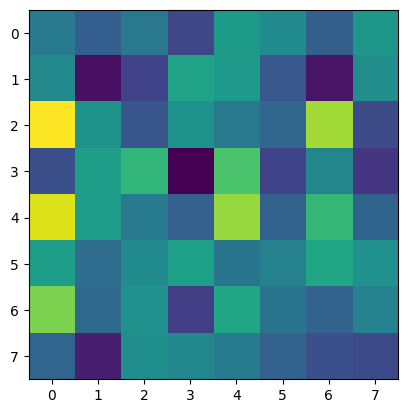

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

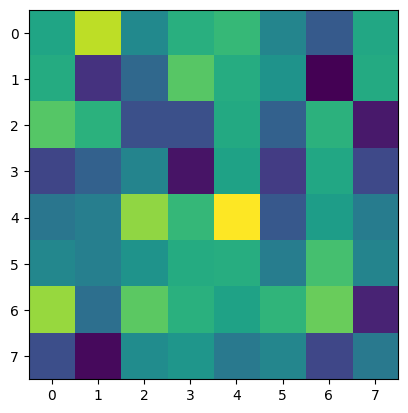

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

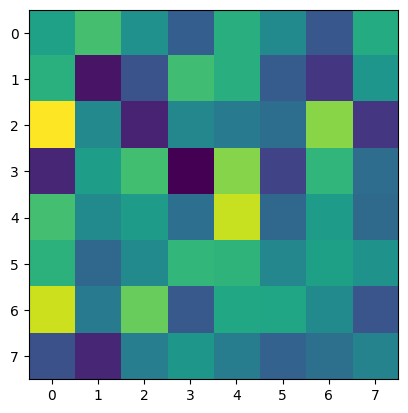

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

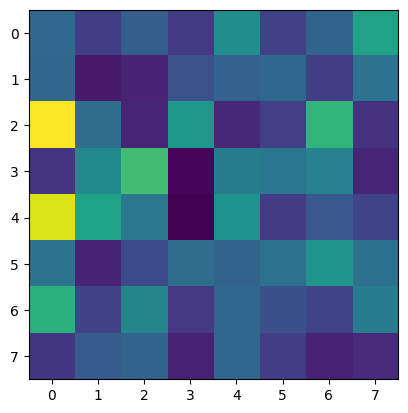

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

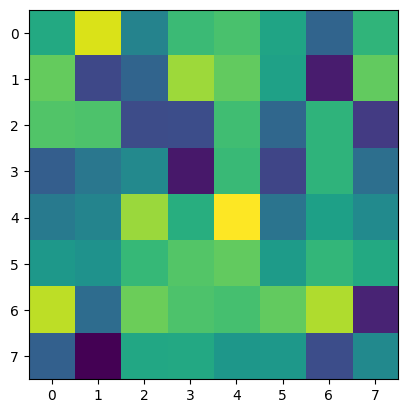

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

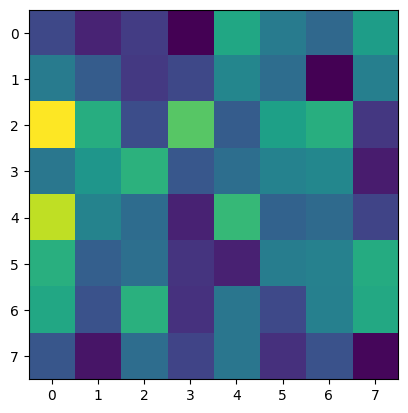

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

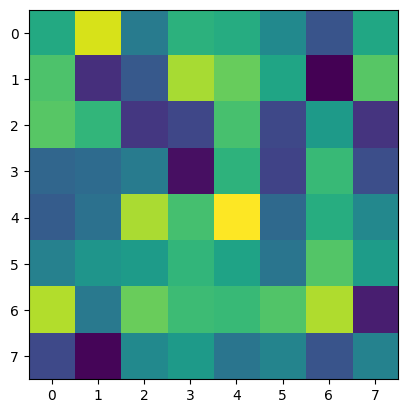

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

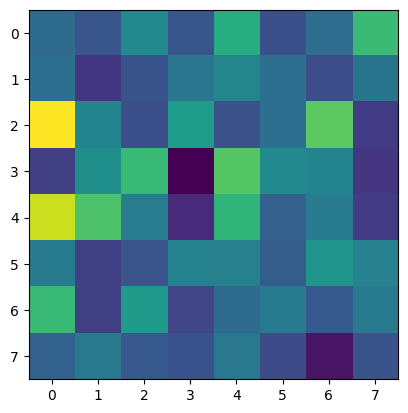

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

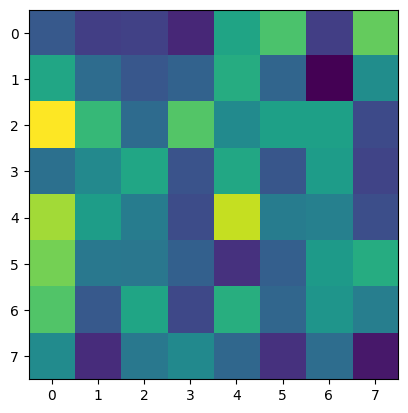

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

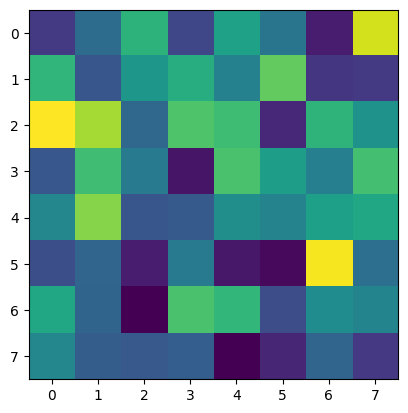

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

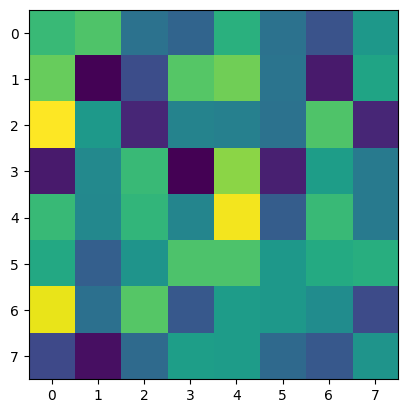

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

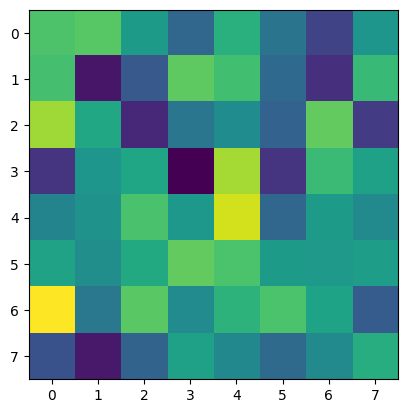

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

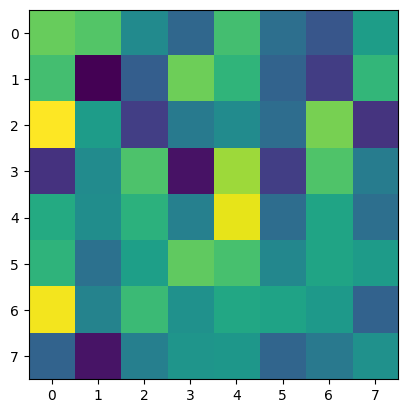

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

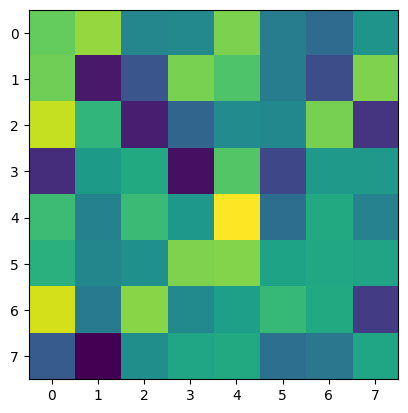

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

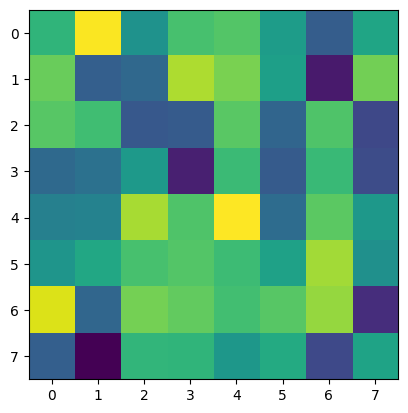

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

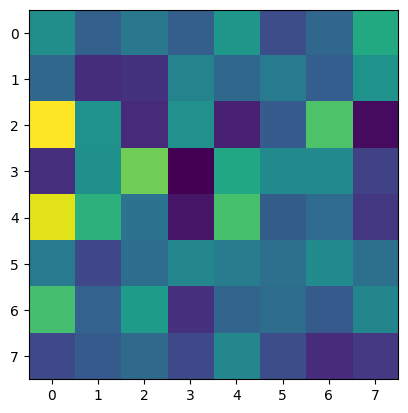

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

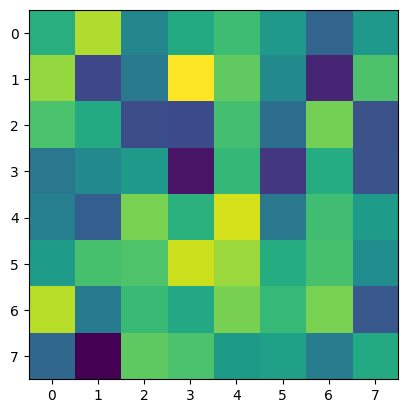

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

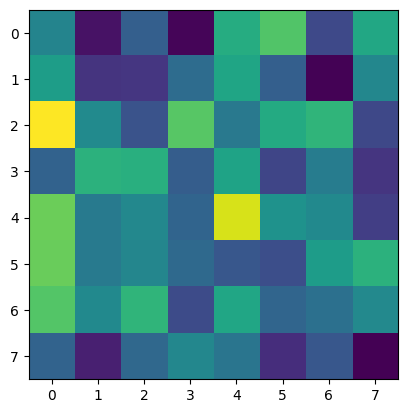

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

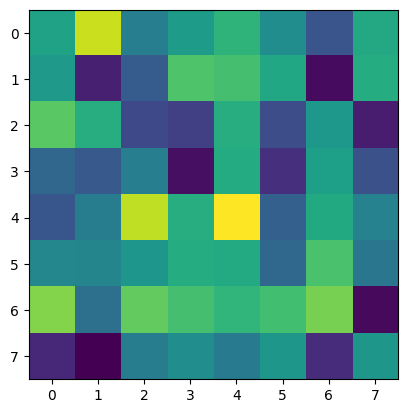

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

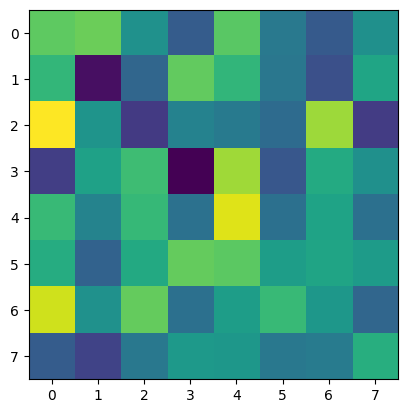

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

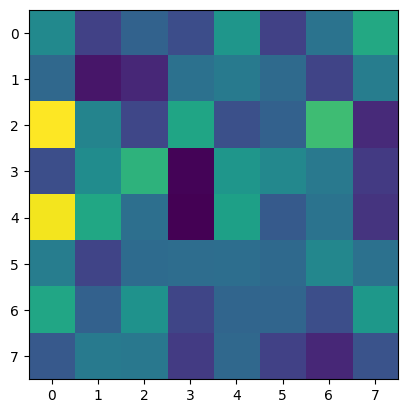

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

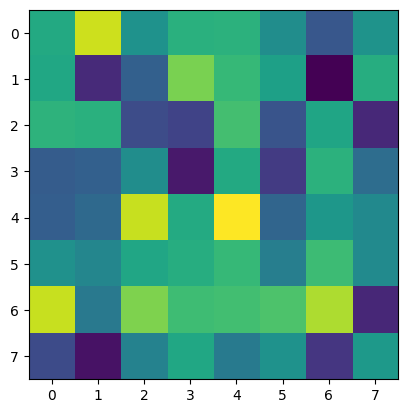

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

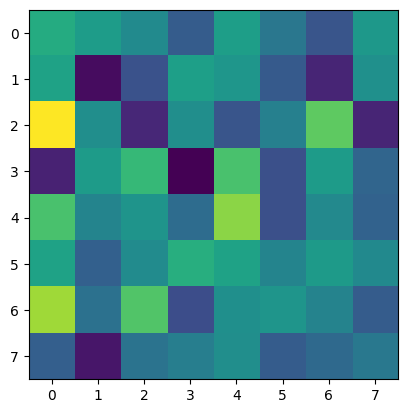

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

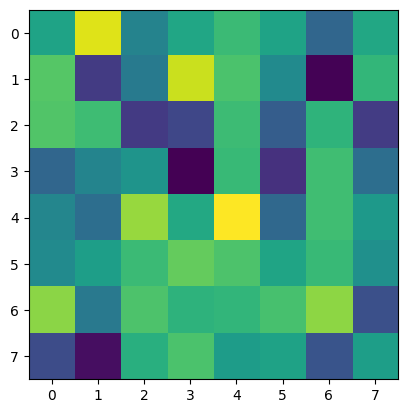

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

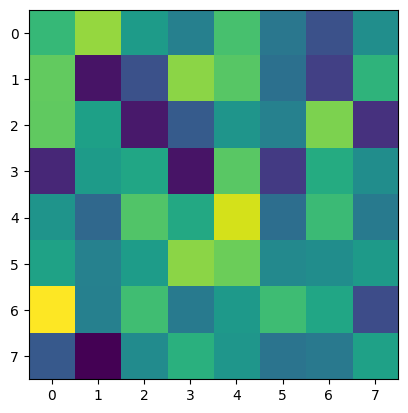

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

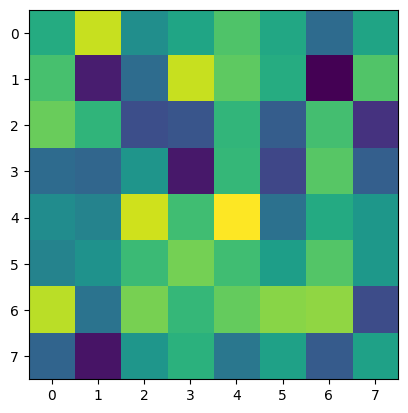

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

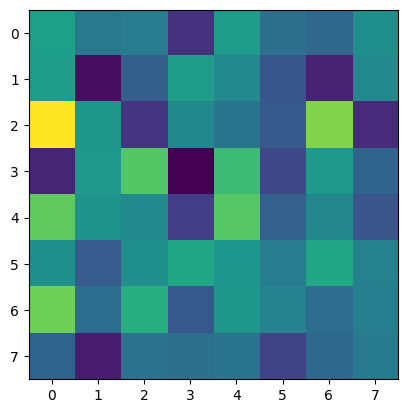

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

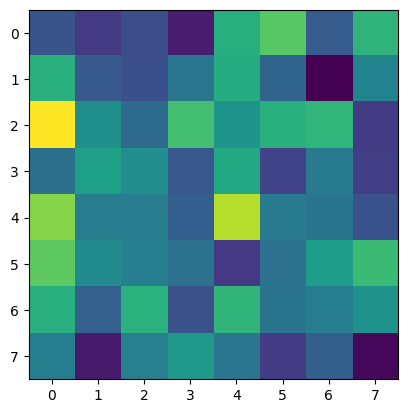

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

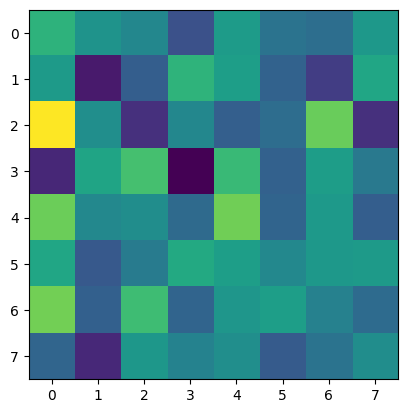

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

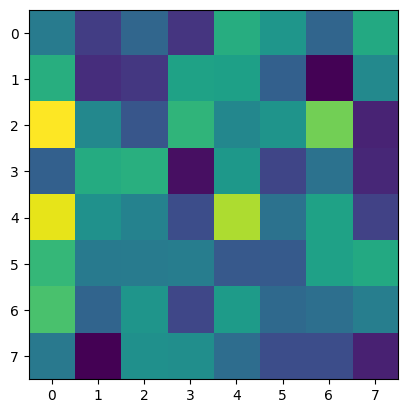

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

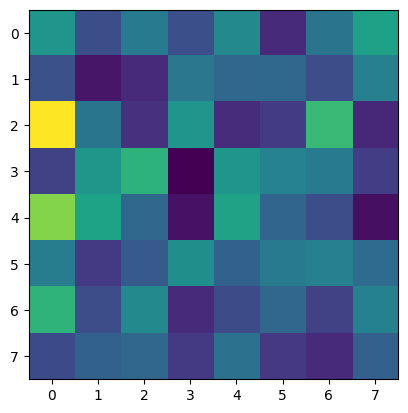

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

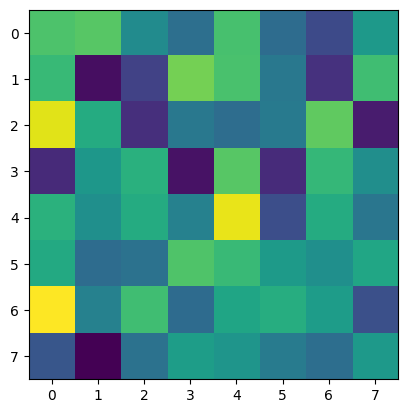

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

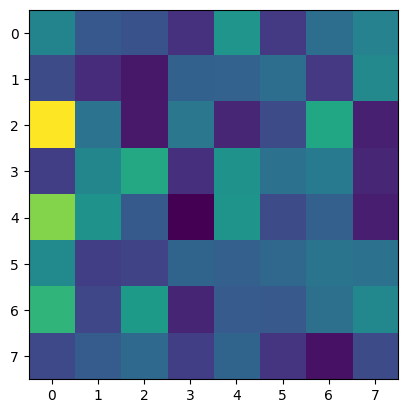

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

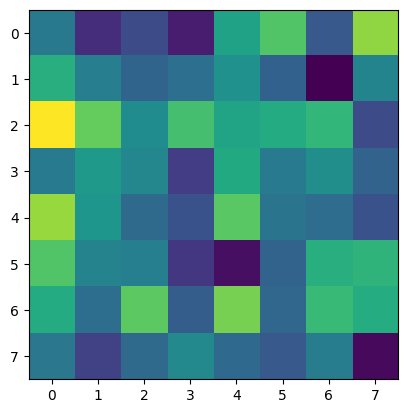

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

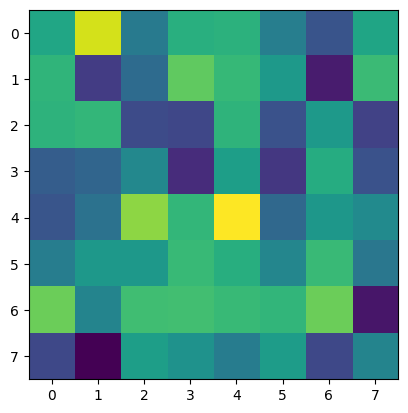

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

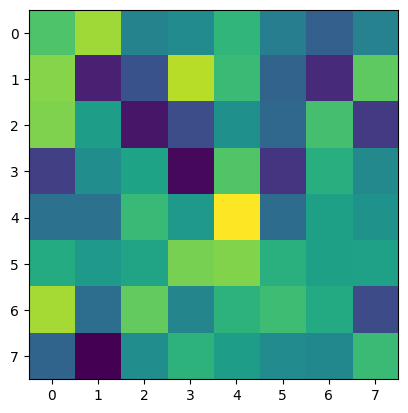

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

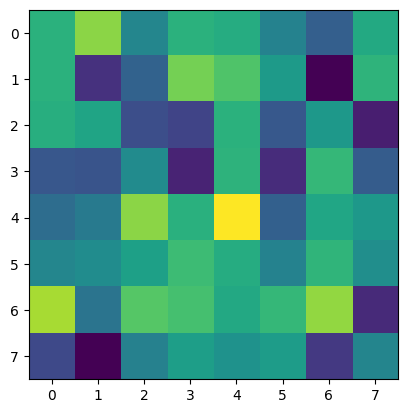

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

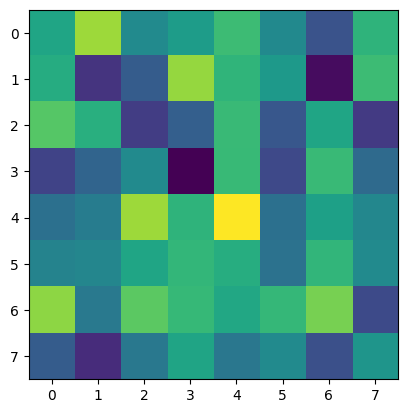

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

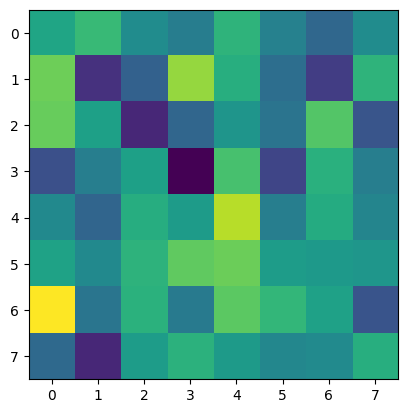

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

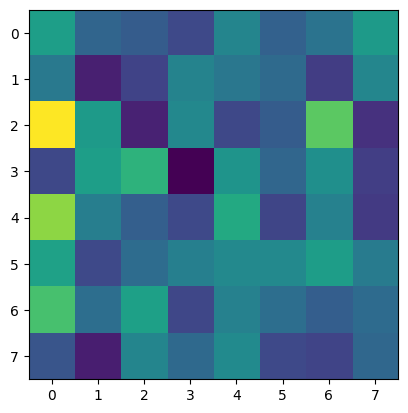

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

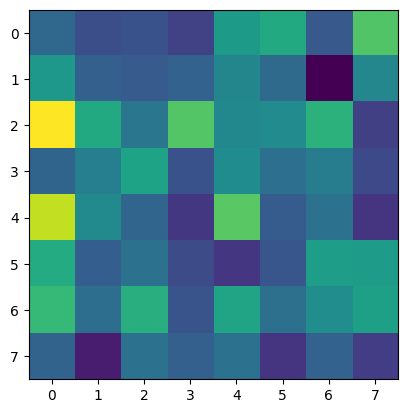

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

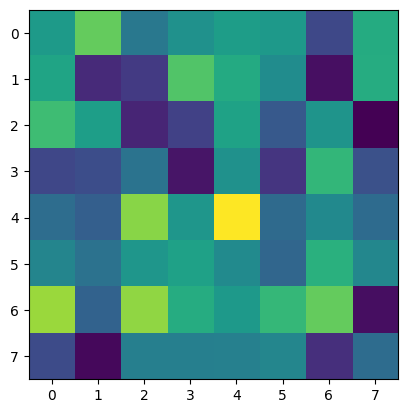

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

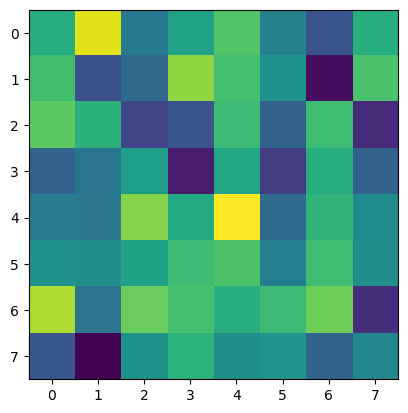

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

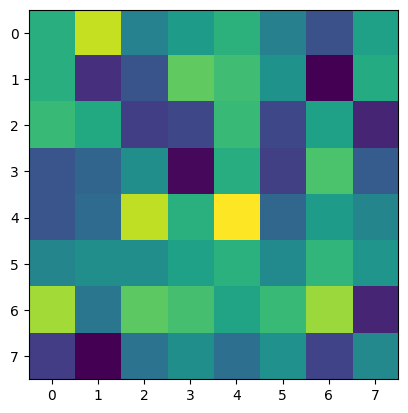

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

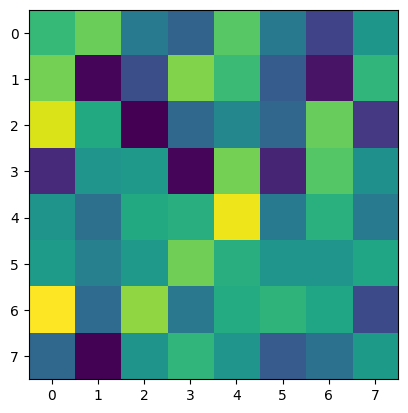

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

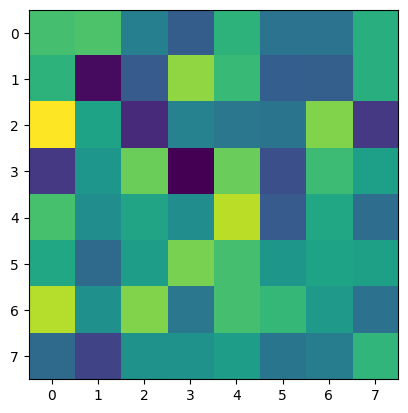

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

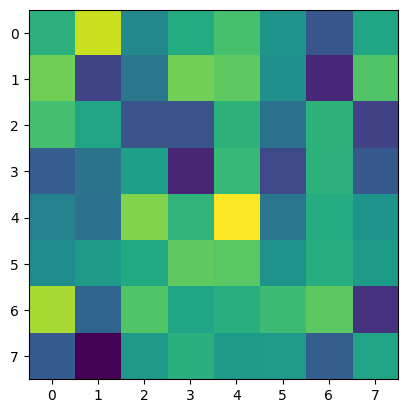

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

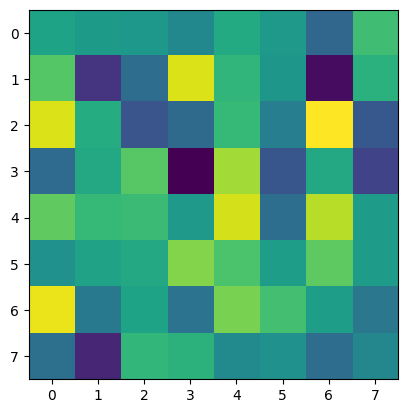

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

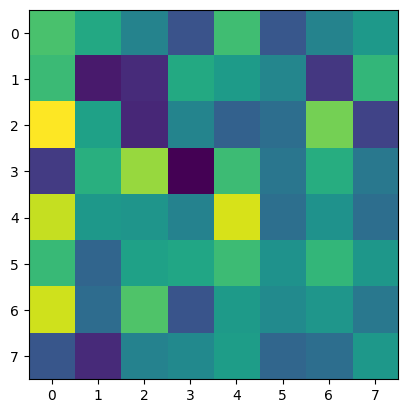

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

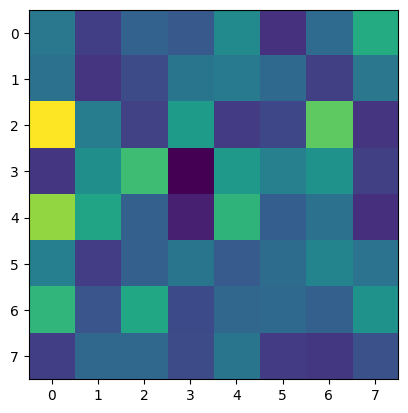

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

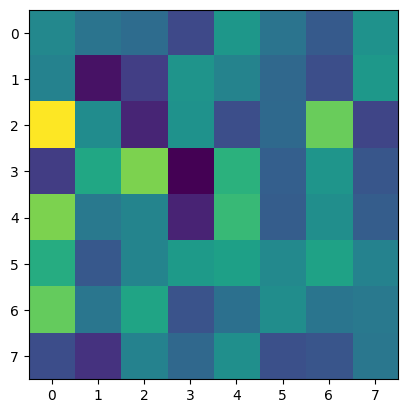

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

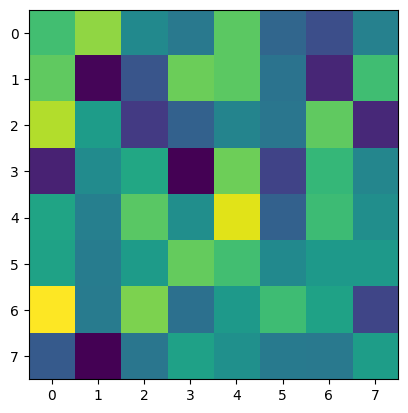

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

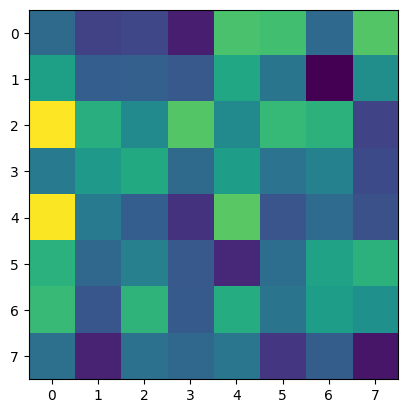

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

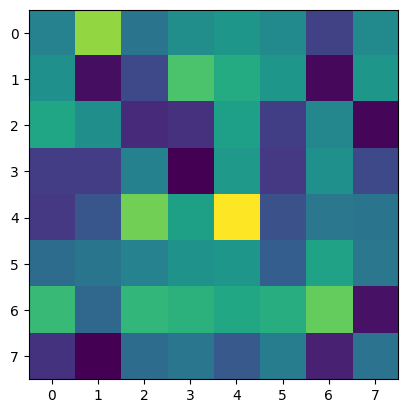

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

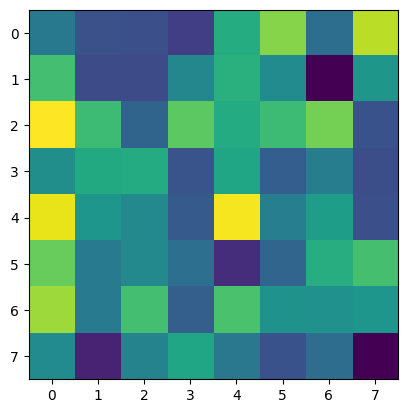

Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.Size([1, 64])
Input x shape: torch.Size([1, 64]), Time embedding shape: torch.

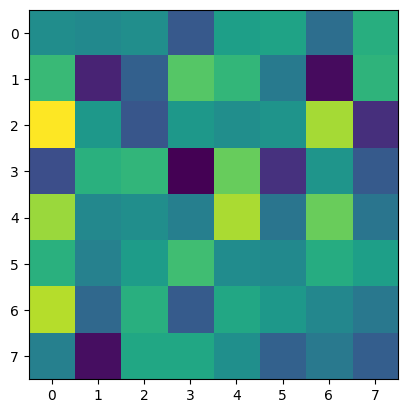

Game Loop Exited


In [12]:

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Diffusion Model Core
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, timesteps):
        super(DiffusionModel, self).__init__()
        self.timesteps = timesteps
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
        )

    def forward(self, x, t):
        # Create a time embedding that matches the shape of x
        t_embedding = torch.full_like(x, fill_value=t / self.timesteps)
        print(f"Input x shape: {x.shape}, Time embedding shape: {t_embedding.shape}")
        return self.net(x + t_embedding)

    def noise_schedule(self, t):
        return 0.1 * (1 - t / self.timesteps)

# Sampling function for real-time generation
def sample_diffusion(model, input_dim, timesteps):
    x = torch.randn(1, input_dim)  # Start with random noise
    trajectory = [x.clone()]
    for t in reversed(range(timesteps)):
        noise = torch.randn_like(x) * model.noise_schedule(t)
        x = model(x, t) - noise
        trajectory.append(x.clone())
    return trajectory

# Training function
def train_diffusion(model, data, timesteps, epochs, lr=1e-3):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for epoch in range(epochs):
        total_loss = 0
        for x in data:
            x = x.to(torch.float32)
            noise = torch.randn_like(x)
            t = torch.randint(0, timesteps, (1,)).item()
            noisy_x = x + model.noise_schedule(t) * noise
            denoised_x = model(noisy_x, t)
            loss = loss_fn(denoised_x, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(data):.4f}")

# Simulating Real-Time Game Loop
def game_loop(model, timesteps, env_dim):
    if int(env_dim ** 0.5) ** 2 != env_dim:
        raise ValueError("env_dim must be a perfect square for visualization.")
    
    print("Real-Time Game Loop: Press Ctrl+C to exit")
    while True:
        try:
            env_state = sample_diffusion(model, env_dim, timesteps)[-1]
            plt.imshow(env_state.view(int(env_dim ** 0.5), int(env_dim ** 0.5)).detach().numpy(), cmap="viridis")
            plt.show(block=False)
            plt.pause(0.1)
            plt.close()
        except KeyboardInterrupt:
            print("Game Loop Exited")
            break

# Synthetic training data
def generate_training_data(num_samples, dim):
    data = []
    for _ in range(num_samples):
        grid = np.random.randint(0, 2, (dim,))
        data.append(torch.tensor(grid, dtype=torch.float32))
    return torch.stack(data)

# Hyperparameters
input_dim = 64  # Assume 8x8 grid for simplicity
hidden_dim = 128
timesteps = 50
epochs = 10

# Prepare data
training_data = generate_training_data(100, input_dim)

# Initialize model
diffusion_model = DiffusionModel(input_dim=input_dim, hidden_dim=hidden_dim, timesteps=timesteps)

# Train model
train_diffusion(diffusion_model, training_data, timesteps, epochs)

# Run game loop
game_loop(diffusion_model, timesteps, input_dim)

